## Uczenie maszynowe UMZ 2019/2020
# 2. Regresja liniowa

## 2.1. Funkcja kosztu

### Zadanie
Znając $x$ – ludność miasta (w dziesiątkach tysięcy mieszkańców),
należy przewidzieć $y$ – dochód firmy transportowej (w dziesiątkach tysięcy dolarów).

(Dane pochodzą z kursu „Machine Learning”, Andrew Ng, Coursera).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.display import display, Math, Latex

### Dane

In [2]:
with open('data01.csv') as data:
    for line in data.readlines()[:10]:
        print(line)

6.1101,17.592

5.5277,9.1302

8.5186,13.662

7.0032,11.854

5.8598,6.8233

8.3829,11.886

7.4764,4.3483

8.5781,12

6.4862,6.5987

5.0546,3.8166



### Wczytanie danych

In [3]:
import csv

reader = csv.reader(open('data01.csv'), delimiter=',')

x = list()
y = list()
for xi, yi in reader:
    x.append(float(xi))
    y.append(float(yi)) 
    
print('x = {}'.format(x[:10])) 
print('y = {}'.format(y[:10]))

x = [6.1101, 5.5277, 8.5186, 7.0032, 5.8598, 8.3829, 7.4764, 8.5781, 6.4862, 5.0546]
y = [17.592, 9.1302, 13.662, 11.854, 6.8233, 11.886, 4.3483, 12.0, 6.5987, 3.8166]


### Hipoteza i parametry modelu

Jak przewidzieć $y$ na podstawie danego $x$? W celu odpowiedzi na to pytanie będziemy starać się znaleźć taką funkcję $h(x)$, która będzie najlepiej obrazować zależność między $x$ a $y$, tj. $y \sim h(x)$.

Zacznijmy od najprostszego przypadku, kiedy $h(x)$ jest po prostu funkcją liniową. Ogólny wzór funkcji liniowej to
$$ h(x) = a \, x + b $$

Pamiętajmy jednak, że współczynniki $a$ i $b$ nie są w tej chwili dane z góry – naszym zadaniem właśnie będzie znalezienie takich ich wartości, żeby $h(x)$ było „możliwie jak najbliżej” $y$ (co właściwie oznacza to sformułowanie, wyjaśnię potem).

Poszukiwaną funkcję $h$ będziemy nazywać **funkcją hipotezy**, a jej współczynniki – **parametrami modelu**.

W teorii uczenia maszynowego parametry modelu oznacza się na ogół grecką literą $\theta$ z odpowiednimi indeksami, dlatego powyższy wzór opisujący liniową funkcję hipotezy zapiszemy jako
$$ h(x) = \theta_0 + \theta_1 x $$

**Parametry modelu** tworzą wektor, który oznaczymy po prostu przez $\theta$:

$$ \theta = \left[\begin{array}{c}\theta_0\\ \theta_1\end{array}\right] $$

Żeby podkreślić fakt, że funkcja hipotezy zależy od parametrów modelu, będziemy pisać $h_\theta$ zamiast $h$:

$$ h_{\theta}(x) = \theta_0 + \theta_1 x $$

Przyjrzyjmy się teraz, jak wyglądają dane, które mamy modelować:

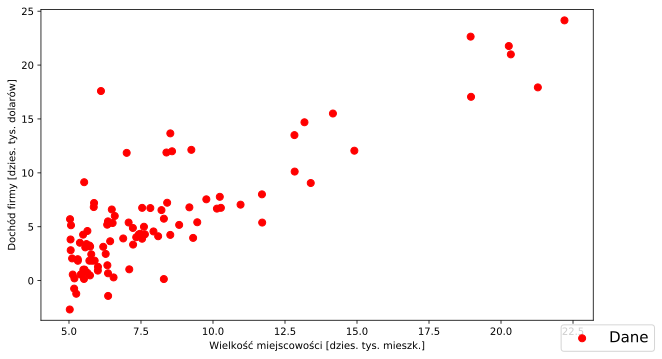

In [4]:
# Funkcje rysujące wykres kropkowy oraz prostą regresyjną

def regdots(x, y):    
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter(x, y, c='r', s=50, label='Dane')
    
    ax.set_xlabel(u'Wielkość miejscowości [dzies. tys. mieszk.]')
    ax.set_ylabel(u'Dochód firmy [dzies. tys. dolarów]')
    ax.margins(.05, .05)
    pl.ylim(min(y) - 1, max(y) + 1)
    pl.xlim(min(x) - 1, max(x) + 1)
    return fig

def regline(fig, fun, theta, x):
    ax = fig.axes[0]
    x0, x1 = min(x), max(x)
    X = [x0, x1]
    Y = [fun(theta, x) for x in X]
    ax.plot(X, Y, linewidth='2',
            label=(r'$y={theta0}{op}{theta1}x$'.format(
                theta0=theta[0],
                theta1=(theta[1] if theta[1] >= 0 else -theta[1]),
                op='+' if theta[1] >= 0 else '-')))

def legend(fig):
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    # try-except block is a fix for a bug in Poly3DCollection
    try:
        fig.legend(handles, labels, fontsize='15', loc='lower right')
    except AttributeError:
        pass

fig = regdots(x,y)
legend(fig)

In [5]:
# Hipoteza: funkcja liniowa jednej zmiennej

def h(theta, x):
    return theta[0] + theta[1] * x

In [6]:
# Przygotowanie interaktywnego wykresu

sliderTheta01 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description=r'$\theta_0$', width=300)
sliderTheta11 = widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description=r'$\theta_1$', width=300)

def slide1(theta0, theta1):
    fig = regdots(x, y)
    regline(fig, h, [theta0, theta1], x)
    legend(fig)

Na poniższym wykresie możesz spróbować ręcznie dopasować parametry modelu $\theta_0$ i $\theta_1$ tak, aby jak najlepiej modelowały zależność między $x$ a $y$:

In [7]:
widgets.interact_manual(slide1, theta0=sliderTheta01, theta1=sliderTheta11)

interactive(children=(FloatSlider(value=0.0, description='$\\theta_0$', max=10.0, min=-10.0), FloatSlider(valu…

<function __main__.slide1(theta0, theta1)>

Skąd wiadomo, że przewidywania modelu (wartości funkcji $h(x)$) zgadzaja się z obserwacjami (wartości $y$)?

Aby to zmierzyć wprowadzimy pojęcie funkcji kosztu.

### Funkcja kosztu

Funkcję kosztu zdefiniujemy w taki sposób, żeby odzwierciedlała ona różnicę między przewidywaniami modelu a obserwacjami.

Jedną z możliwosci jest zdefiniowanie funkcji kosztu jako wartość **błędu średniokwadratowego** (metoda najmniejszych kwadratów, *root-mean-square error, RMSE*):

$$ J(\theta) \, = \, \frac{1}{2m} \sum_{i = 1}^{m} \left( h_{\theta} \left( x^{(i)} \right) - y^{(i)} \right) ^2 $$

gdzie $m$ jest liczbą wszystkich przykładów (obserwacji), czyli wielkością zbioru danych uczących.

W powyższym wzorze sumujemy kwadraty różnic między przewidywaniami modelu ($h_\theta \left( x^{(i)} \right)$) a obserwacjami ($y^{(i)}$) po wszystkich przykładach $i$.

Teraz nasze zadanie sprowadza się do tego, że będziemy szukać takich parametrów $\theta = \left[\begin{array}{c}\theta_0\\ \theta_1\end{array}\right]$, które minimalizują fukcję kosztu $J(\theta)$:

$$ \hat\theta = \mathop{\arg\min}_{\theta} J(\theta) $$

$$ \theta \in \mathbb{R}^2, \quad J \colon \mathbb{R}^2 \to \mathbb{R} $$

Proszę zwrócić uwagę, że dziedziną funkcji kosztu jest zbiór wszystkich możliwych wartości parametrów $\theta$.

$$ J(\theta_0, \theta_1) \, = \, \frac{1}{2m} \sum_{i = 1}^{m} \left( \theta_0 + \theta_1 x^{(i)} - y^{(i)} \right) ^2 $$

In [44]:
def J(h, theta, x, y):
    """Funkcja kosztu"""
    m = len(y)
    return 1.0 / (2 * m) * sum((h(theta, x[i]) - y[i])**2 for i in range(m))

In [45]:
# Oblicz wartość funkcji kosztu i pokaż na wykresie

def regline2(fig, fun, theta, xx, yy):
    """Rysuj regresję liniową"""
    ax = fig.axes[0]
    x0, x1 = min(xx), max(xx)
    X = [x0, x1]
    Y = [fun(theta, x) for x in X]
    cost = J(fun, theta, xx, yy)
    ax.plot(X, Y, linewidth='2',
            label=(r'$y={theta0}{op}{theta1}x, \; J(\theta)={cost:.3}$'.format(
                theta0=theta[0],
                theta1=(theta[1] if theta[1] >= 0 else -theta[1]),
                op='+' if theta[1] >= 0 else '-',
                cost=cost)))

sliderTheta02 = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0, description=r'$\theta_0$', width=300)
sliderTheta12 = widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description=r'$\theta_1$', width=300)

def slide2(theta0, theta1):
    fig = regdots(x, y)
    regline2(fig, h, [theta0, theta1], x, y)
    legend(fig)

Poniższy interaktywny wykres pokazuje wartość funkcji kosztu $J(\theta)$. Czy teraz łatwiej jest dobrać parametry modelu?

In [10]:
widgets.interact_manual(slide2, theta0=sliderTheta02, theta1=sliderTheta12)

interactive(children=(FloatSlider(value=0.0, description='$\\theta_0$', max=10.0, min=-10.0), FloatSlider(valu…

<function __main__.slide2(theta0, theta1)>

### Funkcja kosztu jako funkcja zmiennej $\theta$

Funkcja kosztu zdefiniowana jako RMSE jest funkcją zmiennej wektorowej $\theta$, czyli funkcją dwóch zmiennych rzeczywistych: $\theta_0$ i $\theta_1$.
    
Zobaczmy, jak wygląda jej wykres.

In [11]:
# Wykres funkcji kosztu dla ustalonego theta_1=1.0

def costfun(fun, x, y):
    return lambda theta: J(fun, theta, x, y)

def costplot(hypothesis, x, y, theta1=1.0):
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$J(\theta)$')
    j = costfun(hypothesis, x, y)
    fun = lambda theta0: j([theta0, theta1])
    X = np.arange(-10, 10, 0.1)
    Y = [fun(x) for x in X]
    ax.plot(X, Y, linewidth='2', label=(r'$J(\theta_0, {theta1})$'.format(theta1=theta1)))
    return fig

def slide3(theta1):
    fig = costplot(h, x, y, theta1)
    legend(fig)

sliderTheta13 = widgets.FloatSlider(min=-5, max=5, step=0.1, value=1.0, description=r'$\theta_1$', width=300)

In [12]:
widgets.interact_manual(slide3, theta1=sliderTheta13)

interactive(children=(FloatSlider(value=1.0, description='$\\theta_1$', max=5.0, min=-5.0), Button(description…

<function __main__.slide3(theta1)>

In [13]:
# Wykres funkcji kosztu względem theta_0 i theta_1

from mpl_toolkits.mplot3d import Axes3D
import pylab

%matplotlib inline

def costplot3d(hypothesis, x, y, show_gradient=False):
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_zlabel(r'$J(\theta)$')
    
    j = lambda theta0, theta1: costfun(hypothesis, x, y)([theta0, theta1])
    X = np.arange(-10, 10.1, 0.1)
    Y = np.arange(-1, 4.1, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([[J(hypothesis, [theta0, theta1], x, y) 
                    for theta0, theta1 in zip(xRow, yRow)] 
                   for xRow, yRow in zip(X, Y)])
    
    ax.plot_surface(X, Y, Z, rstride=2, cstride=8, linewidth=0.5,
                    alpha=0.5, cmap='jet', zorder=0,
                    label=r"$J(\theta)$")
    ax.view_init(elev=20., azim=-150)

    ax.set_xlim3d(-10, 10);
    ax.set_ylim3d(-1, 4);
    ax.set_zlim3d(-100, 800);

    N = range(0, 800, 20)
    pl.contour(X, Y, Z, N, zdir='z', offset=-100, cmap='coolwarm', alpha=1)
    
    ax.plot([-3.89578088] * 2,
            [ 1.19303364] * 2,
            [-100, 4.47697137598], 
            color='red', alpha=1, linewidth=1.3, zorder=100, linestyle='dashed',
            label=r'minimum: $J(-3.90, 1.19) = 4.48$')
    ax.scatter([-3.89578088] * 2,
               [ 1.19303364] * 2,
               [-100, 4.47697137598], 
               c='r', s=80, marker='x', alpha=1, linewidth=1.3, zorder=100, 
               label=r'minimum: $J(-3.90, 1.19) = 4.48$')
    
    if show_gradient:
        ax.plot([3.0, 1.1],
                [3.0, 2.4],
                [263.0, 125.0], 
                color='green', alpha=1, linewidth=1.3, zorder=100)
        ax.scatter([3.0],
                   [3.0],
                   [263.0], 
                   c='g', s=30, marker='D', alpha=1, linewidth=1.3, zorder=100)

    ax.margins(0,0,0)
    fig.tight_layout()

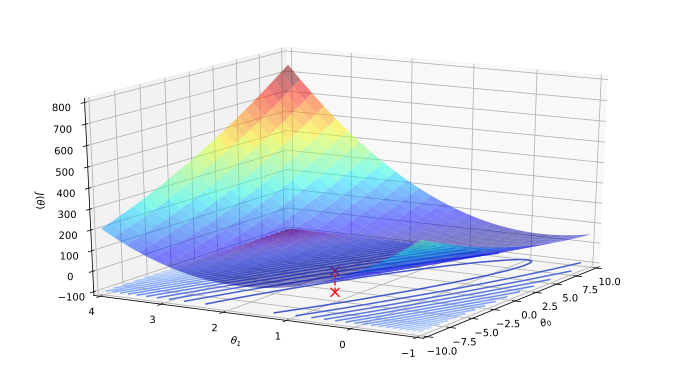

In [14]:
costplot3d(h, x, y)

Na powyższym wykresie poszukiwane minimum funkcji kosztu oznaczone jest czerwonym krzyżykiem.

Możemy też zobaczyć rzut powyższego trójwymiarowego wykresu na płaszczyznę $(\theta_0, \theta_1)$ poniżej:

In [15]:
def costplot2d(hypothesis, x, y, gradient_values=[], nohead=False):
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    
    j = lambda theta0, theta1: costfun(hypothesis, x, y)([theta0, theta1])
    X = np.arange(-10, 10.1, 0.1)
    Y = np.arange(-1, 4.1, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([[J(hypothesis, [theta0, theta1], x, y) 
                    for theta0, theta1 in zip(xRow, yRow)] 
                   for xRow, yRow in zip(X, Y)])
    
    N = range(0, 800, 20)
    pl.contour(X, Y, Z, N, cmap='coolwarm', alpha=1)

    ax.scatter([-3.89578088], [1.19303364], c='r', s=80, marker='x',
               label=r'minimum: $J(-3.90, 1.19) = 4.48$')
    
    if len(gradient_values) > 0:
        prev_theta = gradient_values[0][1]
        ax.scatter([prev_theta[0]], [prev_theta[1]],
                   c='g', s=30, marker='D', zorder=100)
        for cost, theta in gradient_values[1:]:
            dtheta = [theta[0] - prev_theta[0], theta[1] - prev_theta[1]]
            ax.arrow(prev_theta[0], prev_theta[1], dtheta[0], dtheta[1], 
                     color='green', 
                     head_width=(0.0 if nohead else 0.1), 
                     head_length=(0.0 if nohead else 0.2),
                     zorder=100)
            prev_theta = theta
    
    return fig

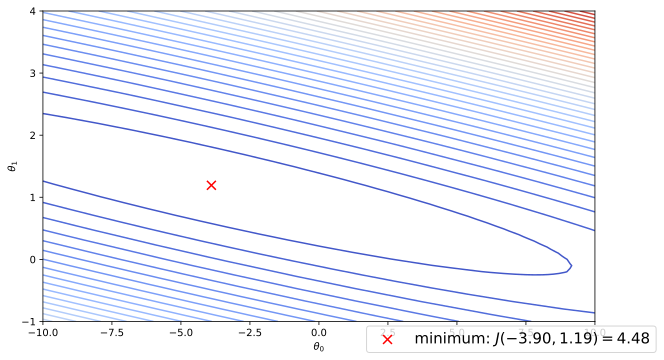

In [16]:
fig = costplot2d(h, x, y)
legend(fig)

### Cechy funkcji kosztu
* $J(\theta)$ jest funkcją wypukłą
* $J(\theta)$ posiada tylko jedno minimum lokalne

## 2.2. Metoda gradientu prostego

### Metoda gradientu prostego
Metoda znajdowania minimów lokalnych.

Idea:
 * Zacznijmy od dowolnego $\theta$.
 * Zmieniajmy powoli $\theta$ tak, aby zmniejszać $J(\theta)$, aż w końcu znajdziemy minimum.

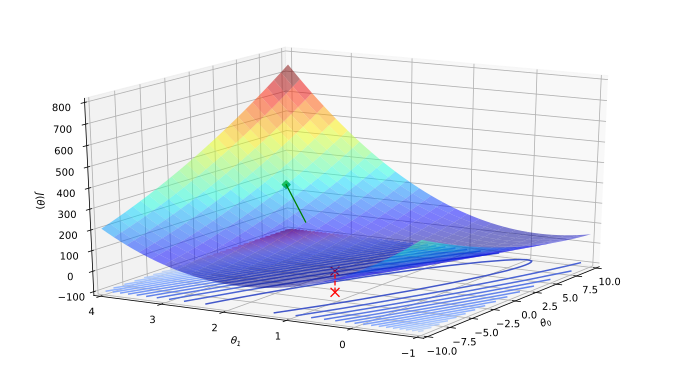

In [17]:
costplot3d(h, x, y, show_gradient=True)

In [18]:
# Przykładowe wartości kolejnych przybliżeń (sztuczne)

gv = [[_, [3.0, 3.0]], [_, [2.6, 2.4]], [_, [2.2, 2.0]], [_, [1.6, 1.6]], [_, [0.4, 1.2]]]

# Przygotowanie interaktywnego wykresu

sliderSteps1 = widgets.IntSlider(min=0, max=3, step=1, value=0, description='kroki', width=300)

def slide4(steps):
    costplot2d(h, x, y, gradient_values=gv[:steps+1])

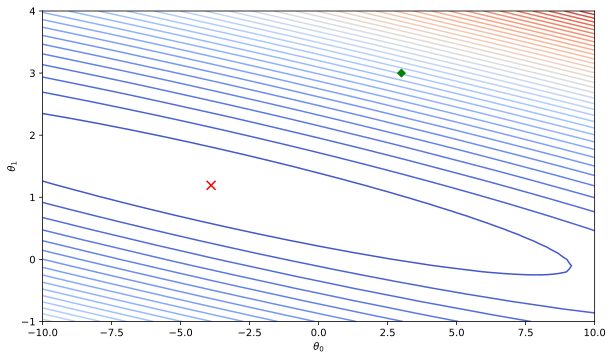

<function __main__.slide4(steps)>

In [19]:
widgets.interact(slide4, steps=sliderSteps1)

### Metoda gradientu prostego
W każdym kroku będziemy aktualizować parametry $\theta_j$:

$$ \theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta) \quad \mbox{ dla każdego } j $$

Współczynnik $\alpha$ nazywamy *długością kroku* lub *współczynnikiem szybkości uczenia* (_learning rate_).

$$ \begin{array}{rcl}
\dfrac{\partial}{\partial \theta_j} J(\theta)
 & = & \dfrac{\partial}{\partial \theta_j} \dfrac{1}{2m} \displaystyle\sum_{i = 1}^{m} \left( h_{\theta} \left( x^{(i)} \right) - y^{(i)} \right) ^2 \\
 & = & 2 \cdot \dfrac{1}{2m} \displaystyle\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) \cdot \dfrac{\partial}{\partial\theta_j} \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) \\
 & = & \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) \cdot \dfrac{\partial}{\partial\theta_j} \left( \displaystyle\sum_{i=0}^n \theta_i x_i^{(i)} - y^{(i)} \right)\\
 & = & \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) -y^{(i)} \right) x_j^{(i)} \\
\end{array} $$

Czyli dla regresji liniowej jednej zmiennej:

$$ h_\theta(x) = \theta_0 + \theta_1x $$

w każdym kroku będziemy aktualizować:

$$
\begin{array}{rcl}
\theta_0 & := & \theta_0 - \alpha \, \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)} \right) \\ 
\theta_1 & := & \theta_1 - \alpha \, \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)} \right) x^{(i)}\\ 
\end{array}
$$

###### Uwaga!
 * W każdym kroku aktualizujemy *jednocześnie* $\theta_0$ i $\theta_1$

 * Kolejne kroki wykonujemy aż uzyskamy zbieżność

### Metoda gradientu prostego – implementacja

In [20]:
# Wyświetlanie macierzy w LaTeX-u

def LatexMatrix(matrix):
    ltx = r'\left[\begin{array}'
    m, n = matrix.shape
    ltx += '{' + ("r" * n) + '}'
    for i in range(m):
        ltx += r" & ".join([('%.4f' % j.item()) for j in matrix[i]]) + r" \\ "
    ltx += r'\end{array}\right]'
    return ltx

In [21]:
def gradient_descent(h, cost_fun, theta, x, y, alpha, eps):
    current_cost = cost_fun(h, theta, x, y)
    log = [[current_cost, theta]]  # log przechowuje wartości kosztu i parametrów
    m = len(y)
    while True:
        new_theta = [
            theta[0] - alpha/float(m) * sum(h(theta, x[i]) - y[i]
                                            for i in range(m)),   
            theta[1] - alpha/float(m) * sum((h(theta, x[i]) - y[i]) * x[i]
                                            for i in range(m))]
        theta = new_theta  # jednoczesna aktualizacja - używamy zmiennej tymaczasowej
        try:
            current_cost, prev_cost = cost_fun(h, theta, x, y), current_cost
        except OverflowError:
            break      
        if abs(prev_cost - current_cost) <= eps:
            break     
        log.append([current_cost, theta])
    return theta, log

In [22]:
best_theta, log = gradient_descent(h, J, [0.0, 0.0], x, y, alpha=0.00001, eps=0.0001)

display(Math(r'\large\textrm{Wynik:}\quad \theta = ' + 
             LatexMatrix(np.matrix(best_theta).reshape(2,1)) + 
            (r' \quad J(\theta) = %.4f' % log[-1][0])  
            + r' \quad \textrm{po %d iteracjach}' % len(log))) 

<IPython.core.display.Math object>

In [23]:
# Przygotowanie interaktywnego wykresu

sliderSteps2 = widgets.IntSlider(min=0, max=500, step=1, value=1, description='kroki', width=300)

def slide5(steps):
    costplot2d(h, x, y, gradient_values=log[:steps+1], nohead=True)

In [24]:
widgets.interact_manual(slide5, steps=sliderSteps2)

interactive(children=(IntSlider(value=1, description='kroki', max=500), Button(description='Run Interact', sty…

<function __main__.slide5(steps)>

### Współczynnik $\alpha$ (długość kroku)

Tempo zbieżności metody gradientu prostego możemy regulować za pomocą parametru $\alpha$, pamiętając, że:

 * Jeżeli długość kroku jest zbyt mała, algorytm może działać zbyt wolno.

 * Jeżeli długość kroku jest zbyt duża, algorytm może nie być zbieżny.

## 2.3. Regresja liniowa wielu zmiennych

Do przewidywania wartości $y$ możemy użyć więcej niż jednej cechy $x$:

### Przykład – ceny mieszkań

In [25]:
reader = csv.reader(open('data02.tsv'), delimiter='\t')
for i, row in enumerate(list(reader)[:10]):
    if i == 0:
        print(' '.join(['{}: {:8}'.format('x' + str(j) if j > 0 else 'y ', entry)
                        for j, entry in enumerate(row)]))
    else:
        print(' '.join(['{:12}'.format(entry) for entry in row]))

y : price    x1: isNew    x2: rooms    x3: floor    x4: location x5: sqrMetres
476118.0     False        3            1            Centrum      78          
459531.0     False        3            2            Sołacz       62          
411557.0     False        3            0            Sołacz       15          
496416.0     False        4            0            Sołacz       14          
406032.0     False        3            0            Sołacz       15          
450026.0     False        3            1            Naramowice   80          
571229.15    False        2            4            Wilda        39          
325000.0     False        3            1            Grunwald     54          
268229.0     False        2            1            Grunwald     90          


$$ x^{(2)} = ({\rm "False"}, 3, 2, {\rm "Sołacz"}, 62), \quad x_3^{(2)} = 2 $$

### Hipoteza

W naszym przypadku (wybraliśmy 5 cech):

$$ h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + \theta_4 x_4 + \theta_5 x_5 $$

W ogólności ($n$ cech):

$$ h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n $$

Jeżeli zdefiniujemy $x_0 = 1$, będziemy mogli powyższy wzór zapisać w bardziej kompaktowy sposób:

$$
\begin{array}{rcl}
h_\theta(x)
 & = & \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n \\
 & = & \displaystyle\sum_{i=0}^{n} \theta_i x_i \\
 & = & \theta^T \, x \\
 & = & x^T \, \theta \\
\end{array}
$$

### Metoda gradientu prostego – notacja macierzowa

Metoda gradientu prostego przyjmie bardzo elegancką formę, jeżeli do jej zapisu użyjemy wektorów i macierzy.

$$
X=\left[\begin{array}{cc}
1 & \left( \vec x^{(1)} \right)^T \\
1 & \left( \vec x^{(2)} \right)^T \\
\vdots & \vdots\\
1 & \left( \vec x^{(m)} \right)^T \\
\end{array}\right] 
= \left[\begin{array}{cccc}
1 & x_1^{(1)} & \cdots & x_n^{(1)} \\
1 & x_1^{(2)} & \cdots & x_n^{(2)} \\
\vdots & \vdots & \ddots & \vdots\\
1 & x_1^{(m)} & \cdots & x_n^{(m)} \\
\end{array}\right]
\quad
\vec{y} = 
\left[\begin{array}{c}
y^{(1)}\\
y^{(2)}\\
\vdots\\
y^{(m)}\\
\end{array}\right]
\quad
\theta = \left[\begin{array}{c}
\theta_0\\
\theta_1\\
\vdots\\
\theta_n\\
\end{array}\right]
$$

In [26]:
# Wczytwanie danych z pliku za pomocą numpy
# Wersje macierzowe funkcji rysowania wykresów punktowych oraz krzywej regresyjnej

data = np.loadtxt('data01.csv', delimiter=',')
m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 0:n].reshape(m, n)

# Dodaj kolumnę jedynek do macierzy
XMx = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
yMx = np.matrix(data[:, 1]).reshape(m, 1)

def hMx(theta, X):
    return X * theta

def regdotsMx(X, y):    
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X[:, 1]], [y], c='r', s=50, label='Dane')
    
    ax.set_xlabel('Populacja')
    ax.set_ylabel('Zysk')
    ax.margins(.05, .05)
    pl.ylim(y.min() - 1, y.max() + 1)
    pl.xlim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    return fig

def reglineMx(fig, fun, theta, X):
    ax = fig.axes[0]
    x0, x1 = np.min(X[:, 1]), np.max(X[:, 1])
    L = [x0, x1]
    LX = np.matrix([1, x0, 1, x1]).reshape(2, 2)
    ax.plot(L, fun(theta, LX), linewidth='2',
            label=(r'$y={theta0:.2}{op}{theta1:.2}x$'.format(
                theta0=float(theta[0][0]),
                theta1=(float(theta[1][0]) if theta[1][0] >= 0 else float(-theta[1][0])),
                op='+' if theta[1][0] >= 0 else '-')))

### Funkcja kosztu – notacja macierzowa

$$J(\theta)=\dfrac{1}{2|\vec y|}\left(X\theta-\vec{y}\right)^T\left(X\theta-\vec{y}\right)$$ 


In [27]:
# Wersja macierzowa funkcji kosztu

def JMx(theta,X,y):
    m = len(y)
    J = 1.0 / (2.0 * m) * ((X * theta - y) . T * ( X * theta - y))
    return J.item()

thetaMx = np.matrix([-5, 1.3]).reshape(2, 1) 

cost = JMx(thetaMx,XMx,yMx) 
display(Math(r'\Large J(\theta) = %.4f' % cost))

<IPython.core.display.Math object>

### Gradient – notacja macierzowa

$$\nabla J(\theta) = \frac{1}{|\vec y|} X^T\left(X\theta-\vec y\right)$$

In [28]:
# Wersja macierzowa gradientu funkcji kosztu

def dJMx(theta,X,y):
    return 1.0 / len(y) * (X.T * (X * theta - y)) 

thetaMx2 = np.matrix([-5, 1.3]).reshape(2, 1)

display(Math(r'\large \theta = ' + LatexMatrix(thetaMx2) + 
             r'\quad' + r'\large \nabla J(\theta) = ' 
             + LatexMatrix(dJMx(thetaMx2,XMx,yMx))))

<IPython.core.display.Math object>

### Algorytm gradientu prostego – notacja macierzowa

$$ \theta := \theta - \alpha \, \nabla J(\theta) $$

In [29]:
# Implementacja algorytmu gradientu prostego za pomocą numpy i macierzy

def GDMx(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-3):
    current_cost = fJ(theta, X, y)
    log = [[current_cost, theta]]
    while True:
        theta = theta - alpha * fdJ(theta, X, y) # implementacja wzoru
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        if abs(prev_cost - current_cost) <= eps:
            break
        log.append([current_cost, theta]) 
    return theta, log

thetaStartMx = np.matrix([0, 0]).reshape(2, 1)

# Zmieniamy wartości alpha (rozmiar kroku) oraz eps (kryterium stopu)
thetaBestMx, log = GDMx(JMx, dJMx, thetaStartMx, 
                        XMx, yMx, alpha=0.01, eps=0.00001)

######################################################################
display(Math(r'\large\textrm{Wynik:}\quad \theta = ' + 
             LatexMatrix(thetaBestMx) + 
             (r' \quad J(\theta) = %.4f' % log[-1][0])  
             + r' \quad \textrm{po %d iteracjach}' % len(log)))  

<IPython.core.display.Math object>

## 2.4. Metoda gradientu prostego w praktyce

### Kryterium stopu

Algorytm gradientu prostego polega na wykonywaniu określonych kroków w pętli. Pytanie brzmi: kiedy należy zatrzymać wykonywanie tej pętli?

W każdej kolejnej iteracji wartość funkcji kosztu maleje o coraz mniejszą wartość.
Parametr `eps` określa, jaka wartość graniczna tej różnicy jest dla nas wystarczająca:

 * Im mniejsza wartość `eps`, tym dokładniejszy wynik, ale dłuższy czas działania algorytmu.
 * Im większa wartość `eps`, tym krótszy czas działania algorytmu, ale mniej dokładny wynik.

Na wykresie zobaczymy porównanie regresji dla różnych wartości `eps`

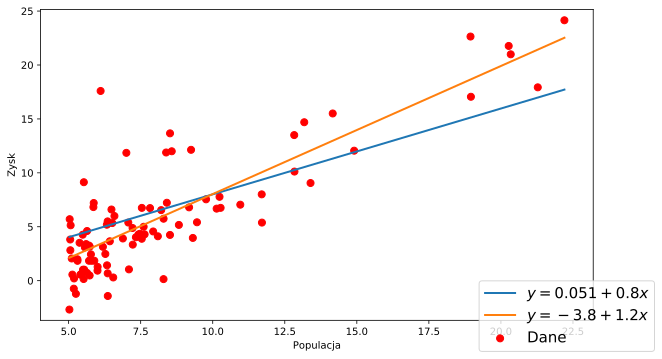

In [47]:
fig = regdotsMx(XMx, yMx)
theta_e1, log1 = GDMx(JMx, dJMx, thetaStartMx, XMx, yMx, alpha=0.01, eps=0.01)  # niebieska linia
reglineMx(fig, hMx, theta_e1, XMx)
theta_e2, log2 = GDMx(JMx, dJMx, thetaStartMx, XMx, yMx, alpha=0.01, eps=0.000001)  # pomarańczowa linia
reglineMx(fig, hMx, theta_e2, XMx)
legend(fig)

In [31]:
display(Math(r'\theta_{10^{-2}} = ' + LatexMatrix(theta_e1) +
             r'\quad\theta_{10^{-6}} = ' + LatexMatrix(theta_e2)))

<IPython.core.display.Math object>

### Długość kroku ($\alpha$)

In [32]:
# Jak zmienia się koszt w kolejnych krokach w zależności od alfa

def costchangeplot(logs):
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlabel('krok')
    ax.set_ylabel(r'$J(\theta)$')

    X = np.arange(0, 500, 1)
    Y = [logs[step][0] for step in X]
    ax.plot(X, Y, linewidth='2', label=(r'$J(\theta)$'))
    return fig

def slide7(alpha):
    best_theta, log = gradient_descent(h, J, [0.0, 0.0], x, y, alpha=alpha, eps=0.0001)
    fig = costchangeplot(log)
    legend(fig)

sliderAlpha1 = widgets.FloatSlider(min=0.01, max=0.03, step=0.001, value=0.02, description=r'$\alpha$', width=300)

In [33]:
widgets.interact_manual(slide7, alpha=sliderAlpha1)

interactive(children=(FloatSlider(value=0.02, description='$\\alpha$', max=0.03, min=0.01, step=0.001), Button…

<function __main__.slide7(alpha)>

## 2.5. Dodatek: regresja liniowa za pomocą macierzy normalnej

Zamiast korzystać z algorytmu gradientu prostego
możemy bezpośrednio obliczyć minimum $J(\theta)$ dla regresji liniowej ze wzoru: 

$$ \theta = \left( X^T X \right)^{-1} \, X^T \, \vec y $$

## 2.6. Normalizacja danych

Normalizacja danych to proces, który polega na dostosowaniu danych wejściowych w taki sposób, żeby ułatwić działanie algorytmowi gradientu prostego.

Wyjaśnię to na przykladzie.

Użyjemy danych z „Gratka flats challenge 2017”.

Rozważmy model $h(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$, w którym cena mieszkania prognozowana jest na podstawie liczby pokoi $x_1$ i metrażu $x_2$:

In [34]:
# Wczytanie danych przy pomocy biblioteki pandas
import pandas
alldata = pandas.read_csv('data_flats.tsv', header=0, sep='\t',
                          usecols=['price', 'rooms', 'sqrMetres'])
alldata[:10]

,price,rooms,sqrMetres
0,476118.00,3,78
1,459531.00,3,62
2,411557.00,3,15
3,496416.00,4,14
4,406032.00,3,15
5,450026.00,3,80
6,571229.15,2,39
7,325000.00,3,54
8,268229.00,2,90
9,604836.00,4,40


In [35]:
# Funkcja, która pokazuje wartości minimalne i maksymalne w macierzy X

def show_mins_and_maxs(XMx):
    mins = np.amin(XMx, axis=0).tolist()[0]  # wartości minimalne
    maxs = np.amax(XMx, axis=0).tolist()[0]  # wartości maksymalne
    for i, (xmin, xmax) in enumerate(zip(mins, maxs)):
        display(Math(
            r'${:.2F} \leq x_{} \leq {:.2F}$'.format(xmin, i, xmax)))

In [36]:
# Przygotowanie danych

import numpy as np

%matplotlib inline

data2 = np.matrix(alldata[['rooms', 'sqrMetres', 'price']])

m, n_plus_1 = data2.shape
n = n_plus_1 - 1
Xn = data2[:, 0:n]

XMx2 = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
yMx2 = np.matrix(data2[:, -1]).reshape(m, 1) / 1000.0

Cechy w danych treningowych przyjmują wartości z zakresu:

In [37]:
show_mins_and_maxs(XMx2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Jak widzimy, $x_2$ przyjmuje wartości dużo większe niż $x_1$.
Powoduje to, że wykres funkcji kosztu jest bardzo „spłaszczony” wzdłuż jednej z osi:

In [38]:
def contour_plot(X, y, rescale=10**8):
    theta0_vals = np.linspace(-100000, 100000, 100)
    theta1_vals = np.linspace(-100000, 100000, 100)

    J_vals = np.zeros(shape=(theta0_vals.size, theta1_vals.size))
    for t1, element in enumerate(theta0_vals):
        for t2, element2 in enumerate(theta1_vals):
            thetaT = np.matrix([1.0, element, element2]).reshape(3,1)
            J_vals[t1, t2] = JMx(thetaT, X, y) / rescale
            
    pl.figure()
    pl.contour(theta0_vals, theta1_vals, J_vals.T, np.logspace(-2, 3, 20))
    pl.xlabel(r'$\theta_1$')
    pl.ylabel(r'$\theta_2$')

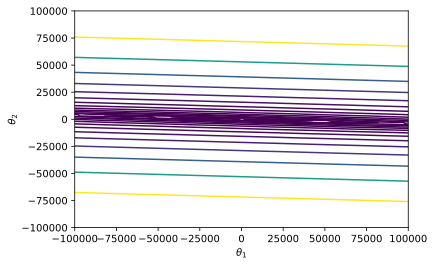

In [39]:
contour_plot(XMx2, yMx2, rescale=10**10)

Jeżeli funkcja kosztu ma kształt taki, jak na powyższym wykresie, to łatwo sobie wyobrazić, że znalezienie minimum lokalnego przy użyciu metody gradientu prostego musi stanowć nie lada wyzwanie: algorytm szybko znajdzie „rynnę”, ale „zjazd” wzdłuż „rynny” w poszukiwaniu minimum będzie odbywał się bardzo powoli.

Jak temu zaradzić?

Spróbujemy przekształcić dane tak, żeby funkcja kosztu miała „ładny”, regularny kształt.

### Skalowanie

Będziemy dążyć do tego, żeby każda z cech przyjmowała wartości w podobnym zakresie.

W tym celu przeskalujemy wartości każdej z cech, dzieląc je przez wartość maksymalną:

$$ \hat{x_i}^{(j)} := \frac{x_i^{(j)}}{\max_j x_i^{(j)}} $$

In [40]:
XMx2_scaled = XMx2 / np.amax(XMx2, axis=0)

show_mins_and_maxs(XMx2_scaled)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

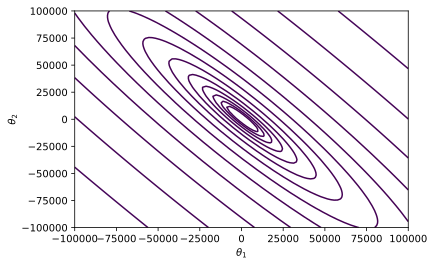

In [41]:
contour_plot(XMx2_scaled, yMx2)

### Normalizacja średniej

Będziemy dążyć do tego, żeby dodatkowo średnia wartość każdej z cech była w okolicach $0$.

W tym celu oprócz przeskalowania odejmiemy wartość średniej od wartości każdej z cech:

$$ \hat{x_i}^{(j)} := \frac{x_i^{(j)} - \mu_i}{\max_j x_i^{(j)}} $$

In [42]:
XMx2_norm = (XMx2 - np.mean(XMx2, axis=0)) / np.amax(XMx2, axis=0)

show_mins_and_maxs(XMx2_norm)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

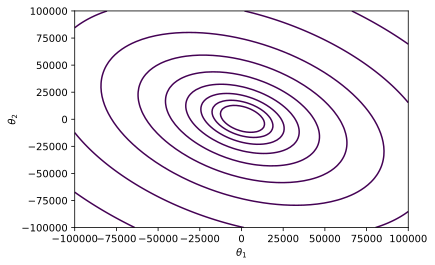

In [43]:
contour_plot(XMx2_norm, yMx2)

Teraz funkcja kosztu ma wykres o bardzo regularnym kształcie – algorytm gradientu prostego zastosowany w takim przypadku bardzo szybko znajdzie minimum funkcji kosztu.